In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
%config Completer.use_jedi = False

In [3]:
data = pd.read_csv('metagenomics/abundance_stoolsubset.csv', dtype='str')
cols = data.columns

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [4]:
### preprocess data ###

# filter for categories of interest

processed = data[data['disease'].isin(['obesity', 'obese', 'overweight','leaness', 'n'])].copy()

# drop columns that are not needed
to_drop = list(cols[2:4]) + list(cols[8:20]) + list(cols[21:211])
processed.drop(columns = to_drop, inplace = True)

# remove samples without bmi, convert bmi to float and filter for regular weight and obese
processed = processed[~processed['bmi'].isin(['na', 'nd'])]

processed['bmi'] = pd.to_numeric(processed['bmi'], downcast ='float')

processed = processed[(processed['bmi']  <= 25) | (processed['bmi'] >= 30)]


In [5]:
# second filtering round, see description below for why
bacteria = list(processed.columns)[7:]

s = re.compile(r's__\w+$')

not_species = [i for i in bacteria if not s.search(i)]

processed.drop(columns = not_species, inplace=True)


# create a new column as labels
processed['label'] = processed['bmi'].apply(lambda x:  0 if (x < 25) else 1)

processed.reset_index(inplace=True, drop=True)

species = processed.columns[7:833]

processed[species] = processed[species].apply(pd.to_numeric)

In [6]:
# rename feature names to shorter one

s = re.compile(r's__(\w+)')

short = []

for i in list(species):
    short.append( s.search(i).group(1).replace("_", " "))
    
new = dict(zip(species, short))

processed.rename(columns = new, inplace=True)

Using BMI to separate into obese and normal. Also should note that the bacteria 

The k/p/c is actually the classification category for the bacteria, c = class, g = genus, o = order, f = family, s = species.

So the bacteria species columns contains a lot of redundant data that are correlated, so have to remove them.

e.g. for Archaea, there are multiple columns, k__archaea is actually the total count of all the archaea detected and then p__Euryarchaeota is the sum of all the classes/genus belonging to these classes. 

use RE to filter for the final level, which is species then type, then filter the columns again to cut down on the features.

t__GCT.. is actually the refseq assembly accession number

<span style= 'color:cyan; font-size:24px'>

* use random search CV for hyperparameters
* feature importance on test model with CV

</span>

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn import metrics
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import balanced_accuracy_score

# shuffle data
#processed = processed.sample(frac=1).reset_index(drop=True)

x = processed.iloc[:, 7:833]

y = processed['label']

# split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 63)

# scale data based on training set
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)


                                                   

#y_test.value_counts()

In [15]:
## Can't remember that this does but seems like it creates dictionary to record feature importance

from collections import Counter

c = Counter(short)

test = dict(c)

dict(sorted(test.items(), key=lambda item: -item[1]))

import csv

with open('dict.csv', 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in test.items():
       writer.writerow([key, value])

In [114]:
def model_performance(model, x, y, n=50):
    ''' does 50 train test splits and calculates model metrics'''
    from sklearn import metrics
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
    
    model.fit(x_train, y_train)
    
    report = metrics.classification_report(y_test, model.predict(x_test), output_dict=True)
    
    report_std = {}
    
    for i in report.keys():
        if i == 'accuracy':
            report_std[i] = []
        else:
            report_std[i] = {}
            for j in report[i].keys():
                report_std[i][j] = []

    
    scoring = ['balanced_accuracy', 'accuracy', 'f1','precision','recall','roc_auc']

    cross_val ={'balanced_accuracy':0, 'accuracy':0, 'f1':0,'precision':0,'recall':0,'roc_auc':0}
        
    cross_val_std ={'balanced_accuracy':[], 'accuracy':[], 'f1':[],'precision':[],'recall':[],'roc_auc':[]}
    
    for count in range(n):
        
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
        
        model.fit(x_train, y_train)
        
        test = metrics.classification_report(y_test, model.predict(x_test), output_dict=True)
        
        for i in report.keys():
            if i == 'accuracy':
                report[i] += test[i]
                report_std[i].append(test[i])
            else:
                for j in report[i].keys():
                    report[i][j] += test[i][j]
                    report_std[i][j].append(test[i][j])
       
        for p in scoring:
            scores = cross_val_score(model, x_train, y_train, scoring = p)

            cross_val[p] += np.mean(scores)
            
            cross_val_std[p].append((np.mean(scores)))
            
    
    for i in scoring:
        print(i)
        print('mean: %0.3f' % (cross_val[i]/n))
        print('std dev: %0.3f' % (np.std(cross_val_std[i])))
        print()
        
    for i in report.keys():
        if i == 'accuracy':
            report[i] = report[i]/(n+1)
            report_std[i] = np.std(report_std[i])
        else:
            for j in report[i].keys():
                report[i][j] = report[i][j]/(n+1)
                report_std[i][j] = np.std(report_std[i][j])
        
    return report, report_std


# def model_performance(model, x, y):
#     ''' 20 fold cross val score'''
#     scoring = ['balanced_accuracy', 'accuracy', 'f1','precision','recall','roc_auc']
    
#     for p in scoring:
#         scores = cross_val_score(model, x, y, cv=20, scoring = p)
#         print(p)
#         print('mean: %0.3f' % np.mean(scores))
#         print('std dev: %0.2f' % np.std(scores))
#         print()

In [ ]:
# correlation plot of features

corr = processed.iloc[:, 7:833].corr()
corr.fillna(0, inplace=True)

fig, ax = plt.subplots(1,1, figsize=(12,8))

sns.heatmap(corr, xticklabels = False, yticklabels = False, ax=ax, cmap='viridis')

# plt.tight_layout()

# plt.savefig('correlation_heatmap.png', dpi=200)

In [ ]:
def model_performance(y_true, y_pred):
    '''prints model metrics'''

    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

    ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot()

    print(classification_report(y_true, log_pred))
    print('balanced accuracy: {0:.4g}'.format(metrics.balanced_accuracy_score(y_true, log_pred)))



### Log regression ###

In [30]:
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform, norm

#log_params = {'penalty':['l1', 'l2']}

# essentially, the hyperparameter c for regularisation strength will be randomly sampled from a uniform dist between 0 - 5
log_params = dict(C=uniform(loc=0, scale=5), penalty=['l2', 'l1'])

# fit log regression
log_reg = LogisticRegression(max_iter=1000)

# randomized hyperparameter search
log_reg_CV = RandomizedSearchCV(log_reg, log_params, n_iter = 50,  scoring = 'balanced_accuracy').fit(x_train, y_train)

log_reg_CV.best_params_

{'C': 0.15220401184507015, 'penalty': 'l2'}

In [33]:
from sklearn.linear_model import LogisticRegression

# refit model with all training data
log_reg_CV.fit(x_train, y_train)

log_pred = log_reg_CV.predict(x_test)
 

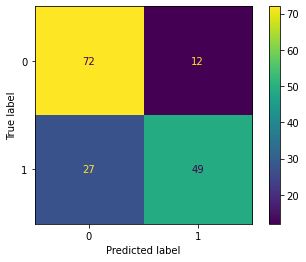

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

log_cm = confusion_matrix(y_test, log_pred)

ConfusionMatrixDisplay(log_cm).plot()

In [48]:
from sklearn.metrics import classification_report

print(classification_report(y_test, log_pred))
print('balanced accuracy: {0:.4g}'.format(metrics.balanced_accuracy_score(y_test, log_pred)))

              precision    recall  f1-score   support

           0       0.73      0.86      0.79        84
           1       0.80      0.64      0.72        76

    accuracy                           0.76       160
   macro avg       0.77      0.75      0.75       160
weighted avg       0.76      0.76      0.75       160

balanced accuracy: 0.7509


### Linear SVM ###

In [54]:
#linear SVM

from sklearn.svm import LinearSVC

linsvm_params = {'penalty':['l1','l2'], 'C':uniform(0, 10)}

lin_svm = LinearSVC(max_iter = 500)

linsvm_cv = RandomizedSearchCV(lin_svm, linsvm_params, n_iter = 50, cv=10, scoring = 'balanced_accuracy').fit(x_train, y_train)

linsvm_cv.best_params_

{'C': 0.29560100832948466, 'penalty': 'l2'}

In [57]:
linsvm_cv.fit(x_train, y_train)

lin_svm_pred = linsvm_cv.predict(x_test)

              precision    recall  f1-score   support

           0       0.73      0.86      0.79        84
           1       0.80      0.64      0.72        76

    accuracy                           0.76       160
   macro avg       0.77      0.75      0.75       160
weighted avg       0.76      0.76      0.75       160

balanced accuracy: 0.7509


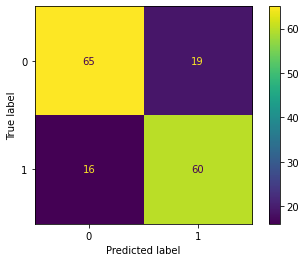

In [59]:
model_performance(y_test, lin_svm_pred)

### Kernel SVM ###

In [ ]:
#step by step optimization

from sklearn.svm import SVC

svm_params = {'kernel':['rbf','sigmoid','poly'], 'gamma':list(np.logspace(-5,5, num=13)), 'C':list(np.logspace(-3,8, num=13))}

svm = SVC(max_iter = 5000)

svm_cv = GridSearchCV(svm, svm_params, scoring = 'balanced_accuracy', n_jobs = 2).fit(x_train, y_train)

svm_cv.best_params_

In [122]:
from sklearn.svm import SVC

svm = SVC(kernel = 'rbf', C = 38.3, gamma = 0.0032)

# model_performance(svm, x_train, y_train)

In [ ]:
report, report_std = model_performance(svm, x, y, n=20)

In [ ]:
report

In [ ]:
report_std

In [66]:
svm.fit(x_train, y_train)

# print(metrics.classification_report(y_test, svm.predict(x_test)))


SVC(C=38.3, gamma=0.0032)

### Decision Tree ###

from sklearn.tree import DecisionTreeClassifier

tree_params = {'criterion':['gini','entropy'], 'max_depth':[p for p in range(50)[5:]], 'min_samples_leaf':list(np.linspace(0.0001,0.25,num=50)), 
               'max_features':['sqrt','log2','None']}

tree = DecisionTreeClassifier()

tree_cv = GridSearchCV(tree, tree_params, scoring = 'balanced_accuracy').fit(x_train, y_train)

tree_cv.best_params_

In [126]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 39, max_features = 'sqrt', min_samples_leaf = 0.0001)

# model_performance(tree, x_train, y_train)

In [ ]:
report, report_std = model_performance(tree, x, y, n=20)

In [ ]:
report

In [ ]:
report_std

In [68]:
tree.fit(x_train, y_train)

# print(metrics.classification_report(y_test, tree.predict(x_test)))


DecisionTreeClassifier(criterion='entropy', max_depth=39, max_features='sqrt',
                       min_samples_leaf=0.0001)

### Random Forest ###

from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier()

forest_params = {'n_estimators':[i for i in range(110)[10::20]], 'max_depth':[j for j in range(81)[5::15]], 
                 'min_samples_leaf':list(np.linspace(0.001,0.25,num=50)), 'max_features':['sqrt','log2']}

forest_cv = GridSearchCV(forest, forest_params, scoring = 'balanced_accuracy', n_jobs=2).fit(x_train, y_train)

forest_cv.best_params_

forest = RandomForestClassifier(max_features = 'sqrt')

forest_params = {'n_estimators':[i for i in range(80)[65:75]], 'max_depth':[j for j in range(80)[60:75:2]], 
                 'min_samples_leaf':list(np.linspace(0.0001,0.1,num=10))}

forest_cv = GridSearchCV(forest, forest_params, scoring = 'balanced_accuracy').fit(x_train, y_train)

forest_cv.best_params_

In [131]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators = 65, min_samples_leaf=0.0001, max_features='sqrt', max_depth = 62)

# model_performance(forest, x_train, y_train)

In [ ]:
report, report_std = model_performance(forest, x, y, n=20)

In [ ]:
report

In [ ]:
report_std

In [70]:
forest.fit(x_train, y_train)

# print(metrics.classification_report(y_test, forest.predict(x_test)))


RandomForestClassifier(max_depth=62, max_features='sqrt',
                       min_samples_leaf=0.0001, n_estimators=65)

### Naive Bayes ###

In [17]:
from sklearn.naive_bayes import GaussianNB

naive = GaussianNB()

# model_performance(naive, x_train, y_train)

In [18]:
naive.fit(x_train, y_train)

print(metrics.classification_report(y_test, naive.predict(x_test)))


GaussianNB()

### Adaboost ###

from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier()

ada_params = {'n_estimators':[i for i in range(150)[100:130]]}

ada_cv = GridSearchCV(ada, ada_params, scoring = 'balanced_accuracy', n_jobs=2).fit(x_train, y_train)

ada_cv.best_params_

In [135]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators = 117)

# model_performance(ada, x_train, y_train)

In [ ]:
report, report_std = model_performance(ada, x, y, n=20)

In [ ]:
report

In [ ]:
report_std

In [72]:
ada.fit(x_train, y_train)

# print(metrics.classification_report(y_test, ada.predict(x_test)))


AdaBoostClassifier(n_estimators=117)

### Gradient Boost ###

from sklearn.ensemble import GradientBoostingClassifier

grad = GradientBoostingClassifier()

grad_params = {'n_estimators':[i for i in range(200)[100:300:20]]}

grad_cv = GridSearchCV(grad, grad_params).fit(x_train, y_train)

grad = GradientBoostingClassifier()

grad_params = {'n_estimators':[i for i in range(200)[125:150:5]], 'max_depth':[i for i in range(16)[3::2]]}

grad_cv = GridSearchCV(grad, grad_params).fit(x_train, y_train)

grad = GradientBoostingClassifier(n_estimators = 145, max_depth = 5)

grad_params = {'max_features':['sqrt','log2','auto','None']}

grad_cv = GridSearchCV(grad, grad_params).fit(x_train, y_train)

In [148]:
from sklearn.ensemble import GradientBoostingClassifier

grad = GradientBoostingClassifier(n_estimators = 145, max_depth = 5)

# model_performance(grad, x_train, y_train)

In [ ]:
grad = GradientBoostingClassifier()

report, report_std = model_performance(grad, x, y, n=20)

In [ ]:
report

In [ ]:
report_std

In [74]:
grad.fit(x_train, y_train)

# print(metrics.classification_report(y_test, grad.predict(x_test)))


GradientBoostingClassifier(max_depth=5, n_estimators=145)

In [ ]:

fig, ax = plt.subplots(1,2, figsize = (22,12))

#plot ROC curve

metrics.plot_roc_curve(log_reg, x_test, y_test, ax = ax[0], name = "Log Reggression")
metrics.plot_roc_curve(lin_svm, x_test, y_test, ax = ax[0], name = "Linear SVM")
metrics.plot_roc_curve(svm, x_test, y_test, ax = ax[0], name = "kernel SVM")
# metrics.plot_roc_curve(naive, x_test, y_test, ax = ax[0], name = "Naive Bayes")
metrics.plot_roc_curve(tree, x_test, y_test, ax = ax[0], name = "Decision Tree")
metrics.plot_roc_curve(forest, x_test, y_test, ax = ax[0], name = "Random Forest", ls = "-.", color='r', linewidth = 2)
metrics.plot_roc_curve(ada, x_test, y_test, ax = ax[0], name = "Adaboost")
metrics.plot_roc_curve(grad, x_test, y_test, ax = ax[0], name = "Gradient Boosting", ls = '--', color='black', linewidth=2)
ax[0].tick_params(axis='both', labelsize= 14)
ax[0].set_xlabel('False Postive Rate', fontsize = 24)
ax[0].set_ylabel('True Postive Rate', fontsize = 24)
ax[0].text(-0.08, 1.065, "A", fontsize=24, fontweight='bold', va='top', ha='right')
ax[0].legend(fontsize = 14)

#plot precision-recall curve

metrics.plot_precision_recall_curve(log_reg, x_test, y_test, ax = ax[1], name = "Log Reggression")
metrics.plot_precision_recall_curve(lin_svm, x_test, y_test, ax = ax[1], name = "Linear SVM")
metrics.plot_precision_recall_curve(svm, x_test, y_test, ax = ax[1], name = "kernel SVM")
# metrics.plot_precision_recall_curve(naive, x_test, y_test, ax = ax[1], name = "Naive Bayes")
metrics.plot_precision_recall_curve(tree, x_test, y_test, ax = ax[1], name = "Decision Tree")
metrics.plot_precision_recall_curve(forest, x_test, y_test, ax = ax[1], name = "Random Forest", ls = "-.", color='r', linewidth = 2)
metrics.plot_precision_recall_curve(ada, x_test, y_test, ax = ax[1], name = "Adaboost")
metrics.plot_precision_recall_curve(grad, x_test, y_test, ax = ax[1], name = "Gradient Boosting", ls = '--', color='black', linewidth=2)
ax[1].set_xlabel('Recall', fontsize = 24)
ax[1].set_ylabel('Precision', fontsize = 24)
ax[1].legend(loc = 'lower left',fontsize=14)
ax[1].tick_params(axis='both', labelsize= 16)
ax[1].text(-0.08, 1.035, "B", fontsize=24, fontweight='bold', va='top', ha='right')


plt.tight_layout()
plt.savefig('performance',dpi=300)


#always put savefig before show(), if not will save empty image.
plt.show()

### Dataframe of permutation importance of better performing models ###

### Also the plots ###

In [13]:
from sklearn.inspection import permutation_importance

# forest_importance = permutation_importance(forest, x_test, y_test, scoring = 'balanced_accuracy', n_jobs = 2, random_state = 42)

# ada_importance = permutation_importance(ada, x_test, y_test, scoring = 'balanced_accuracy', n_jobs = 2, random_state = 42)

grad_importance = permutation_importance(grad, x_test, y_test, scoring = 'balanced_accuracy', n_jobs = 2, n_repeats = 100, random_state = 42)

# svm_importance = permutation_importance(svm, x_test, y_test, scoring = 'balanced_accuracy', n_jobs = 2, random_state = 42)


In [47]:
# features = list(processed.columns[7:-1])

In [59]:
# perm_impt = pd.DataFrame(columns = ['Features', 'Forest','Grad', 'Ada', 'SVM'])

# perm_impt['Features'] = features

# perm_impt['Forest'] = forest_importance['importances_mean']

# perm_impt['Ada'] = ada_importance['importances_mean']

# perm_impt['Grad'] = grad_importance['importances_mean']

# perm_impt['SVM'] = svm_importance['importances_mean']

#perm_impt.to_csv('permutation_importance.csv', index=False)

In [60]:
# perm_impt = pd.read_csv('feature_importance.csv')

# forest_impt = list(perm_impt['Features'][perm_impt['Forest'] > 0])

# ada_impt = list(perm_impt['Features'][perm_impt['Ada'] > 0])

# grad_impt = list(perm_impt['Features'][perm_impt['Grad'] > 0])


In [31]:
# feature_count = []

# for model in ['Forest','Grad', 'Ada']:
#     feature_count.append((perm_impt[model] > 0).value_counts()[True])


In [63]:
# from matplotlib_venn import venn2

# forest_impt = list(perm_impt['Features'][perm_impt['Forest'] > 0])
# grad_impt = list(perm_impt['Features'][perm_impt['Grad'] > 0])
# ada_impt = list(perm_impt['Features'][perm_impt['Ada'] > 0])
# svm_impt = list(perm_impt['Features'][perm_impt['SVM'] > 0])


In [ ]:
# x_labels = ['Random Forest','Gradient Boost', 'AdaBoost']

# # Plot the figure.
# fig, ax = plt.subplots(1,1, figsize = (14,10), facecolor = 'white')

# ax = pd.Series(feature_count).plot(kind='bar')
# ax.set_title('No. of Important Features', fontsize = 18, fontweight = 'bold', pad = 10)
# ax.set_xlabel('Classifier', fontsize = 16, fontweight = 'bold', labelpad = 10)
# ax.set_ylabel('Count',  fontsize = 16, fontweight = 'bold', labelpad = 10)
# ax.set_xticklabels(x_labels, rotation = 0, fontsize = 14)

# rects = ax.patches

# # Make some labels.

# for rect, label in zip(rects, feature_count):
#     height = rect.get_height()
#     ax.text(rect.get_x() + rect.get_width() / 2, height + 1, label,
#             ha='center', va='bottom', fontsize = 14)

# plt.savefig('impt_feature_count.png', dpi=150)
    
# plt.show()


In [163]:
diabetes_impt = pd.read_csv('dict_diabetes.csv', names=['features', 'count'])

grad_impt = pd.read_csv('dict_obs.csv', names=['features', 'count'])

cirr_impt = pd.read_csv('dict_cirrhosis.csv', names=['features', 'count'])

In [ ]:
from venn import venn

test = {'Obesity':set(grad_impt['features']), 'Diabetes':set(diabetes_impt['features'])} #, 'Cirrhosis':set(cirr_impt['features'])}

fig, ax = plt.subplots(1,1, figsize = (14,10), facecolor='white')

venn(test, fontsize = 18, legend_loc = 'lower left', ax=ax)

#ax.set_title('Feature Overlap between Classifiers', fontsize = 18, fontweight ='bold', y=0.90)

plt.tight_layout()

plt.savefig('venn_diagram.png', dpi=200)



In [54]:
del test

### Gradient Boost analysis ###

In [6]:

#grad_perm.to_csv('grad_perm_impt.csv', index=False)

grad_perm = pd.read_csv('obs_avg_impt.csv')

In [ ]:
from sklearn.inspection import permutation_importance

from sklearn.ensemble import GradientBoostingClassifier

impt_score = np.zeros((826,))

for i in range(50):
    # split data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

    grad = GradientBoostingClassifier(n_estimators = 145, max_depth = 5).fit(x_train, y_train)
    
    perm_impt = permutation_importance(grad, x_test, y_test, scoring='balanced_accuracy', n_jobs = 2)
    
    # filter dataset
    
    impt_score += perm_impt['importances_mean']
    
temp1 = pd.DataFrame(columns = ['features','impt'])
    
temp1['features'] = short
temp1['impt'] = impt_score/50
    
temp2 = temp1[temp1['impt'] > 0].copy()
temp2.sort_values(by='impt', ascending=False, inplace=True, ignore_index=True)

In [113]:
temp2[:10]

,features,impt
0,Klebsiella pneumoniae,0.022613
1,Bacteroides intestinalis,0.010920
2,Bacteroides stercoris,0.005639
3,Bacteroides pectinophilus,0.003882
4,Streptococcus thermophilus,0.003866
5,Ruminococcus obeum,0.003856
6,Bacteroides massiliensis,0.003327
7,Sutterella wadsworthensis,0.003230
8,Prevotella copri,0.002498
9,Barnesiella intestinihominis,0.002216


In [115]:
temp2.to_csv('obs_avg_impt.csv', index_label=None)

In [150]:
# dataframe of impt bacteria and permutation importance

# grad_perm = pd.DataFrame(columns = ['Features','importances_mean', 'importances_std'])
# grad_perm['Features'] = species
# grad_perm['importances_mean'] = grad_importance['importances_mean']
# grad_perm['importances_std'] = grad_importance['importances_std']
# grad_perm = grad_perm[grad_perm['importances_mean'] > 0].copy()
# grad_perm.sort_values(by='importances_mean', ascending=False, inplace=True, ignore_index=True)

In [78]:
test = list(temp2[:11]['features'])

test.pop(8)

'Streptococcus australis'

In [80]:
# dataframe with all data including BMI, country etc

stuff = list(processed.columns[:7]) + test + ['label']

grad_stuff = processed[stuff]

In [82]:
# changing labels for control and obese

#grad_stuff = grad_means.copy()

grad_stuff['label'][grad_stuff['label'] == 1] = 'Obese'

grad_stuff['label'][grad_stuff['label'] == 0] = 'Ctrl'

In [89]:
# calculate mean species abundance for each species

means = grad_stuff.groupby(by = 'label').mean().iloc[:,1:]

# create a dataframe for mean abundance

grad_means = pd.DataFrame(columns = ['Bacteria','Ctrl','Obese'])

grad_means['Bacteria'] = test
grad_means['Ctrl'] = list(means.iloc[0, :10])
grad_means['Obese'] = list(means.iloc[1, :10])

In [123]:
mann = []

for i in test:
    ctrl = grad_stuff[i][grad_stuff['label'] == 'Ctrl']
    fat = grad_stuff[i][grad_stuff['label'] == 'Obese']
    mann.append(sp.stats.mannwhitneyu(ctrl, fat))

In [133]:
mann

[MannwhitneyuResult(statistic=50021.0, pvalue=5.743462986209846e-29),
 MannwhitneyuResult(statistic=56065.0, pvalue=1.0373227210850577e-13),
 MannwhitneyuResult(statistic=53000.5, pvalue=4.4726913092891246e-14),
 MannwhitneyuResult(statistic=54095.0, pvalue=1.7819259764379774e-13),
 MannwhitneyuResult(statistic=74871.0, pvalue=0.0913742088911158),
 MannwhitneyuResult(statistic=56985.0, pvalue=3.5359461021296864e-11),
 MannwhitneyuResult(statistic=76291.5, pvalue=0.3969552609320985),
 MannwhitneyuResult(statistic=54231.0, pvalue=4.563468300691354e-13),
 MannwhitneyuResult(statistic=76269.0, pvalue=0.40894672831154855),
 MannwhitneyuResult(statistic=72018.0, pvalue=0.06459181295598002)]

In [ ]:
ind = np.arange(len(grad_means))

width = 0.4

fig, ax = plt.subplots(figsize = (16,10))

color = ['royalblue', 'orange']
ax.barh(ind, grad_means.Ctrl, width, color = color[1], label = 'Ctrl', edgecolor ='black')
ax.barh(ind + width, grad_means.Obese, width, color = color[0], label = 'Obese', edgecolor ='black')
ax.set(yticks = ind + width/2, yticklabels = grad_means.Bacteria)
#ax.set_title('Mea', fontsize = 18, fontweight='bold', pad=20)
#ax.set_xscale('log')
ax.set_ylabel('Species', fontsize = 18, fontweight='bold')
ax.set_xlabel("Relative Abundance", fontsize = 18, fontweight = 'bold', labelpad = 20)
ax.legend(loc='lower right', fontsize = 'x-large')
ax.tick_params(axis='both', labelsize = 14)
plt.gca().invert_yaxis()

plt.savefig('Grad_impt_abundance.png', dpi=200, bbox_inches = "tight")

plt.show()

In [ ]:
plt.figure(figsize=(12,8))

plt.plot(temp2['impt'])

plt.xlabel('Species', fontsize = 16, fontweight = 'bold', labelpad=10)
plt.tick_params(axis='both', labelsize=10)

plt.ylabel('Permutation Importance', fontsize = 16, fontweight = 'bold', labelpad=10)

plt.tight_layout()

plt.savefig('grad_perm_impt_line.png', dpi=200)

In [93]:
test

['Klebsiella pneumoniae',
 'Bacteroides intestinalis',
 'Dorea longicatena',
 'Bacteroides stercoris',
 'Bacteroides pectinophilus',
 'Bacteroides massiliensis',
 'Clostridium sp L2 50',
 'Barnesiella intestinihominis',
 'Streptococcus thermophilus',
 'Ruminococcus obeum']

grad_perm = perm_impt[['Features','Grad']].copy()

grad_perm = grad_perm[grad_perm['Grad'] > 0].copy()

# sort from highest to lowest importance
grad_perm.sort_values(by='Grad', ascending=False, inplace=True, ignore_index=True)

impt_features = grad_perm['Features'].copy()


regex to shorten species names

c = re.compile(r's__(\w+)')

short = []

for i in grad_perm['Features']:
    short.append( c.search(i).group(1).replace("_", " "))
    
grad_perm['Features'] = short


create a list of features we want from the original data
stuff = list(processed.columns[:7]) + list(impt_features) + ['label']

# filter the original dataset

grad_stuff = processed[stuff].copy()

# change bacteria name to be shorter
new = dict(zip(impt_features, short))

grad_stuff.rename(columns = new, inplace=True)

# changing labels for control and obese
grad_stuff['label'][grad_stuff['label'] == 1] = 'Obese'

grad_stuff['label'][grad_stuff['label'] == 0] = 'Ctrl'

# calculate mean species abundance for each species

means = grad_stuff.groupby(by = 'label').mean().iloc[:,1:]

# create a dataframe for mean abundance

grad_means = pd.DataFrame(columns = ['Bacteria','Ctrl','Obese'])

grad_means['Bacteria'] = short
grad_means['Ctrl'] = list(means.iloc[0, :])
grad_means['Obese'] = list(means.iloc[1, :])

# plots permutation importance and abundance

fig, ax = plt.subplots(1,2, figsize=(16,10))


ax[0].plot(grad_perm['Grad'])
ax[0].set_xlabel('Species', fontsize=18, labelpad = 10)
ax[0].set_ylabel('Permutation importance', fontsize=18, labelpad = 10)
ax[0].tick_params(axis="both", labelsize=14)

ax[1].scatter([range(len(grad_perm))], grad_means['Ctrl'])
ax[1].scatter([range(len(grad_perm))], grad_means['Obese'])
ax[1].set_xlabel('Species', fontsize=18, labelpad = 10)
ax[1].set_ylabel('Species Abundance', fontsize=18, labelpad = 5)
ax[1].tick_params(axis="both", labelsize=14)
ax[1].legend(['Control','Obese'], fontsize = 'xx-large')

plt.tight_layout()
plt.savefig('grad_perm_importance.png', dpi=150)
plt.show()


### Comparison plots for the 11 common ones ###

In [66]:
# this one basically finds the common species in all models
common = [i for i in species if (i in forest_impt) and (i in grad_impt) and (i in ada_impt)]

# this one is to remove the s__ in the species names
c = re.compile(r's__(\w+)')

short = []

for i in common:
    short.append( c.search(i).group(1).replace("_", " "))

In [68]:
# filers the feature importance table to see the 8 common species got what coefficient

common_impt = perm_impt[perm_impt['Features'].isin(common)]

In [69]:
# create a new table from the original table that consists of the 8 common bacteria and the other info

common_only = processed[(list(processed.columns[:7]) + common + ['label'])]

common_only['label'][common_only['label'] == 1] = 'Obese'

common_only['label'][common_only['label'] == 0] = 'Ctrl'

# rename the columns to the shortened bacteria name 
common_only.rename(columns = dict(zip(common_only.columns[7:-1], short)), inplace =True)


# create 2 dataframes with mean and std dev for each species and BMI

means = common_only.groupby(by = 'label').mean().iloc[:,1:]
error = common_only.groupby(by = 'label').std().iloc[:,1:]

In [70]:
#  creates a dataframe with species name, then the mean species abundance for controls and obese groups then plot a barchart

compare_means = pd.DataFrame(columns = ['Bacteria','Ctrl','Obese'])

compare_means['Bacteria'] = short
compare_means['Ctrl'] = list(means.iloc[0, :])
compare_means['Obese'] = list(means.iloc[1, :])

# compare_means.plot(x = 'Bacteria', y = ['Ctrl', 'Obese'], kind='barh', title = 'All', logx=True, figsize = (14,8), 
#                    xlabel = 'Mean Relative Abundance', ylabel = 'Bacteria', fontsize=14)

In [ ]:
create_summary(common_only, list(common_only['country']))

In [ ]:
create_summary(common_only, ['china'], name= "China", filename = 'china_8_common.png')

In [74]:
# this functions calculates the mean of the relative abundance and plots barcharts. 
# Take note that it uses some variables that were declared earlier, so it is not entirely standalone. No need to remove the categorical stuff
# since groupby removes them

def create_summary(dataframe, group, name = 'Unnamed', filename = ('Unnamed' + '.png'), color = ['royalblue', 'orange']):

    #create new DF with the group of interest
    grouped = dataframe[dataframe['country'].isin(group)].copy()
    
    # create 2 dataframes with mean and std dev for each species and BMI

    g_means = grouped.groupby(by = 'label').mean().iloc[:,1:]
    g_error = grouped.groupby(by = 'label').std().iloc[:,1:]

    #  creates a dataframe with species name, then the mean species abundance for controls and obese groups then plot a barchart

    grouped_means = pd.DataFrame(columns = ['Bacteria','Ctrl','Obese'])

    grouped_means['Bacteria'] = short
    grouped_means['Ctrl'] = list(g_means.iloc[0, :])
    grouped_means['Obese'] = list(g_means.iloc[1, :])

    ind = np.arange(len(grouped_means))

    width = 0.4

    fig, ax = plt.subplots(figsize = (16,10))


    ax.barh(ind, grouped_means.Obese, width, color = color[0], label = 'Obese')
    ax.barh(ind + width, grouped_means.Ctrl, width, color = color[1], label = 'Ctrl')
    ax.set(yticks = ind + width, yticklabels = grouped_means.Bacteria)
    ax.set_title(name, fontsize = 18, fontweight='bold', pad=20)
    ax.set_xscale('log')
    ax.set_ylabel('Species', fontsize = 18, fontweight='bold')
    ax.set_xlabel("Log Relative Abundance", fontsize = 18, fontweight = 'bold', labelpad = 20)
    ax.legend(loc='lower right', fontsize = 'x-large')
    ax.tick_params(axis='both', labelsize = 14)
    plt.gca().invert_yaxis()
    
    #plt.savefig(filename, dpi=150, bbox_inches = "tight")
    
    plt.show()

In [ ]:
create_summary(common_only, ['china'], name= "China", filename = 'china_8_common.png')

### Random Forest feature analysis ### 

In [98]:
test = processed.iloc[:, 7:-1].corr()

In [107]:
test.fillna(0, inplace=True)

In [ ]:
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(test, xticklabels=False, yticklabels =False, cmap = cmap)

In [ ]:
data['dataset_name'].value_counts()

In [44]:
# create dataframe that contains all impt features from random forest model and sort them

forest_perm = perm_impt[['Features','Forest']].copy()

forest_perm = forest_perm[forest_perm['Forest'] > 0].copy()

forest_perm.sort_values(by='Forest', ascending=False, inplace=True, ignore_index=True)

impt_features = forest_perm['Features'].copy()


# regex to shorten species names

c = re.compile(r's__(\w+)')

short = []

for i in forest_perm['Features']:
    short.append( c.search(i).group(1).replace("_", " "))

forest_perm['Features'] = short

# create a list of features we want from the original data
stuff = list(processed.columns[:7]) + list(impt_features) + ['label']

# filter the original dataset

forest_stuff = processed[stuff].copy()

# change bacteria name to be shorter
new = dict(zip(impt_features, short))

forest_stuff.rename(columns = new, inplace=True)

# changing labels for control and obese
forest_stuff['label'][forest_stuff['label'] == 1] = 'Obese'

forest_stuff['label'][forest_stuff['label'] == 0] = 'Ctrl'


In [40]:
# calculate mean species abundance for each species

means = forest_stuff.groupby(by = 'label').mean().iloc[:,1:]

# create a dataframe for mean abundance

forest_means = pd.DataFrame(columns = ['Bacteria','Ctrl','Obese'])

forest_means['Bacteria'] = short
forest_means['Ctrl'] = list(means.iloc[0, :])
forest_means['Obese'] = list(means.iloc[1, :])



In [ ]:
# dual plot of perm importance and species abundance

fig, ax = plt.subplots(1,2, figsize=(16,10))


ax[0].plot(forest_perm['Forest'])
ax[0].set_xlabel('Species', fontsize=18, labelpad = 10)
ax[0].set_ylabel('Permutation importance', fontsize=18, labelpad = 10)
ax[0].tick_params(axis="both", labelsize=14)

ax[1].scatter([range(35)], forest_means['Ctrl'])
ax[1].scatter([range(35)], forest_means['Obese'])
ax[1].set_xlabel('Species', fontsize=18, labelpad = 10)
ax[1].set_ylabel('Species Abundance', fontsize=18, labelpad = 5)
ax[1].tick_params(axis="both", labelsize=14)
ax[1].legend(['Control','Obese'], fontsize = 'xx-large')

plt.tight_layout()
plt.savefig('forest_perm_importance.png', dpi=150)
plt.show()


In [54]:
# plot barchart

create_summary(forest_stuff, list(forest_stuff['country'].unique()), name='forest')

eu = ['denmark', 'spain', 'sweden', 'germany','france', 'iceland']

# create_summary(forest_stuff, eu, name='forest')

In [55]:
# find the common and different points

# create dataframe of the EU and CN data and obtain their means
eu_only = forest_stuff[forest_stuff['country'].isin(eu)]

cn_only = forest_stuff[forest_stuff['country'].isin(['china'])]

eu_mean = eu_only.groupby(by='label').mean().drop(columns = 'bmi').transpose().reset_index()

cn_mean = cn_only.groupby(by='label').mean().drop(columns = 'bmi').transpose().reset_index()

eu_mean['ctrl_larger'] = eu_mean['Ctrl'] > eu_mean['Obese']

cn_mean['ctrl_larger'] = cn_mean['Ctrl'] > cn_mean['Obese']

# agreement dataframe

eu_mean['agreement'] = eu_mean['ctrl_larger'] & cn_mean['ctrl_larger']

agreed = eu_mean[['index','agreement']][eu_mean['agreement'] == True].copy()

In [57]:
# common and differences for the EU countries

den = forest_stuff[forest_stuff['country'].isin(['denmark'])]

#france = forest_stuff[forest_stuff['country'].isin(['france'])]

den_mean = den.groupby(by='label').mean().drop(columns = 'bmi').transpose().reset_index()

#france_mean = france.groupby(by='label').mean().drop(columns = 'bmi').transpose().reset_index()

den_mean['ctrl_larger'] = den_mean['Ctrl'] > den_mean['Obese']

#france_mean['ctrl_larger'] = france_mean['Ctrl'] > france_mean['Obese']

# agreement dataframe

den_mean['agreement'] = den_mean['ctrl_larger'] & cn_mean['ctrl_larger']

#agreed = eu_mean[['index','agreement']][eu_mean['agreement'] == True].copy()

In [ ]:
#create new DF with the group of interest

# grouped = forest_stuff[ list(agreed['index']) + ['label'] ]

# create 2 dataframes with mean and std dev for each species and BMI

# g_means = grouped.groupby(by='label').mean().iloc[:,:]
# g_error = grouped.groupby(by= 'label').std().iloc[:,:]

#  creates a dataframe with species name, then the mean species abundance for controls and obese groups then plot a barchart

# grouped_means = pd.DataFrame(columns = ['Bacteria','Ctrl','Obese'])

# grouped_means['Bacteria'] = list(grouped.columns[:-1])
# grouped_means['Ctrl'] = list(g_means.iloc[0, :])
# grouped_means['Obese'] = list(g_means.iloc[1, :])

ind = np.arange(len(grouped_means))

width = 0.4

fig, ax = plt.subplots(figsize = (16,10))

color = ['royalblue', 'orange']
ax.barh(ind, grouped_means.Obese, width, color = color[0], label = 'Obese')
ax.barh(ind + width, grouped_means.Ctrl, width, color = color[1], label = 'Ctrl')
ax.set(yticks = ind + width, yticklabels = grouped_means.Bacteria)
ax.set_title('test', fontsize = 18, fontweight='bold', pad=20)
ax.set_xscale('log')
ax.set_ylabel('Species', fontsize = 18, fontweight='bold')
ax.set_xlabel("Log Relative Abundance", fontsize = 18, fontweight = 'bold', labelpad = 20)
ax.legend(loc='lower right', fontsize = 'x-large')
ax.tick_params(axis='both', labelsize = 14)
plt.gca().invert_yaxis()

# #plt.savefig(filename, dpi=150, bbox_inches = "tight")

plt.show()

In [ ]:
eu_mean['label'][eu_mean['agreement']==True]

In [78]:
# let's try comparing importance with abundance

forest_perm['relative_impt'] = forest_perm['Forest'].div(forest_perm['Forest'].sum(), axis=0)